In [15]:
#first we get weather data

# before import use pip install git+https://github.com/stephanpcpeters/HourlyHistoricWeather.git#egg=historicdutchweather
# or include the following line (without comment) in requirements.txt and run `pip install -r requirements.txt` in a terminal
# -e git+https://github.com/stephanpcpeters/HourlyHistoricWeather.git#egg=historicdutchweather
import historicdutchweather

from datetime import datetime
from datetime import timedelta

# firsttest just a short timeseries

pseudonym = 886307
start = datetime(2021,12, 19)
end = datetime(2022, 3, 17)

#save dataframe with corresponding pseudonym number
file_name = str(pseudonym) + '.xlsx'

# utimately: #min, max dates of the analysis
# start = datetime(2021,10,21)
# stop = datetime(2022,4,30)

#location: center of Assendorp neighbourhood in Zwolle
lat, lon = 52.5065500000,6.0996100000

weather = historicdutchweather.get_local_weather(start, end, lat, lon, metrics=['T', 'FH', 'Q'])

Model 2


/home/jovyan/twomes-analysis-pipeline/src/historicdutchweather/historicdutchweather/main.py:67: DtypeWarning: Columns (15,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, comment="#", skiprows=30, skip_blank_lines=True, names=__headerline)
/home/jovyan/twomes-analysis-pipeline/src/historicdutchweather/historicdutchweather/main.py:67: DtypeWarning: Columns (3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, comment="#", skiprows=30, skip_blank_lines=True, names=__headerline)


Got a value error for station 258
Will skip for now


/home/jovyan/twomes-analysis-pipeline/src/historicdutchweather/historicdutchweather/main.py:67: DtypeWarning: Columns (3,15,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, comment="#", skiprows=30, skip_blank_lines=True, names=__headerline)


Got a value error for station 275
Will skip for now


100% 2112/2112 [00:28<00:00, 73.67it/s]


In [16]:
# use of the database requires the .env file in the root folder of the repo to be filled with the proper credentials

import math
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import scipy.optimize
import scipy.interpolate

import sys
sys.path.append('../data/')
from extractor import Extractor, Period
import openpyxl

In [17]:
#TODO functions below can probably be generalized further with functions as parameters

def get_home_parameter_timeseries_sum(home: int, parameter: str, seriesname: str, 
                             differentiate: bool, upsample_to: str, downsample_to: str,
                             start: datetime, end: datetime, tz_name_source: str, tz_name_home: str) -> pd.DataFrame:
    extractor = Extractor(pseudonym, Period(start, end))
    timeseriesdata = extractor.get(parameter)
    
   
    timeseriesdata.set_index('datetime', inplace=True)
    if tz_name_source == tz_name_home:
        timeseriesdata = timeseriesdata.tz_localize(tz_name_source)
    else:
        timeseriesdata = timeseriesdata.tz_localize(tz_name_source).tz_convert(tz_name_home)
    
    #first sort on datetime index
    timeseriesdata.sort_index(inplace=True)
    #then deduplicate the series
    timeseriesdata.drop_duplicates(inplace=True)
        
    # Converting str to float
    timeseriesdata['value'] = timeseriesdata['value'].astype(float)
    
    timeseriesdata_minute = timeseriesdata.resample(upsample_to).first()
    
    timeseriesdata_minute.interpolate(method='time', inplace=True)
    if differentiate:
        timeseriesdata_minute['target_value'] = timeseriesdata_minute['value'].diff().shift(-1)
    else:
        timeseriesdata_minute['target_value'] = timeseriesdata_minute['value']
    timeseriesdata_minute['target_value'] = timeseriesdata_minute['target_value'].fillna(0)
    timeseriesdata_minute.rename(columns={'target_value':seriesname}, inplace=True)
    timeseriesdata_by_day = timeseriesdata_minute[seriesname].resample(downsample_to).sum()

    print(seriesname)
    print(timeseriesdata_by_day.describe())

    return timeseriesdata_by_day

def get_meter_parameter_timeseries_sum(home: int, parameter: str, seriesname: str, 
                             differentiate: bool, upsample_to: str, downsample_to: str,
                             start: datetime, end: datetime, tz_name_source: str, tz_name_home: str) -> pd.DataFrame:
    extractor = Extractor(pseudonym, Period(start, end))
    timeseriesdata = extractor.get(parameter)
    
    timeseriesdata.set_index('datetime', inplace=True)
    if tz_name_source == tz_name_home:
        timeseriesdata = timeseriesdata.tz_localize(tz_name_source)
    else:
        timeseriesdata = timeseriesdata.tz_localize(tz_name_source).tz_convert(tz_name_home)
    
    #first sort on datetime index
    timeseriesdata.sort_index(inplace=True)
    #then deduplicate the series
    timeseriesdata.drop_duplicates(inplace=True)
    
    # Converting str to float
    timeseriesdata['value'] = timeseriesdata['value'].astype(float)
    

    # meter values should always be rising monotonic 
    # meter value resets, which occasionaly happen, should be removed
    # also, small occasional negative meter jumps should be ignored
    # so first calculate diff, filter out the negative jumps and recalculate the meter value, starting at zero
    timeseriesdata['value'] = timeseriesdata['value'].diff().fillna(0).clip(0,None).cumsum()


    timeseriesdata_minute = timeseriesdata.resample(upsample_to).first()
    timeseriesdata_minute.interpolate(method='time', inplace=True)
    if differentiate:
        timeseriesdata_minute['target_value'] = timeseriesdata_minute['value'].diff().shift(-1)
    else:
        timeseriesdata_minute['target_value'] = timeseriesdata_minute['value']
    timeseriesdata_minute['target_value'] = timeseriesdata_minute['target_value'].fillna(0)
    timeseriesdata_minute.rename(columns={'target_value':seriesname}, inplace=True)
    timeseriesdata_by_day = timeseriesdata_minute[seriesname].resample(downsample_to).sum()

    print(seriesname)
    print(timeseriesdata_by_day.describe())

    return timeseriesdata_by_day

def get_home_parameter_timeseries_count(home: int, parameter: str, seriesname: str, 
                             differentiate: bool, upsample_to: str, downsample_to: str,
                             start: datetime, end: datetime, tz_name_source: str, tz_name_home: str) -> pd.DataFrame:
    extractor = Extractor(pseudonym, Period(start, end))
    timeseriesdata = extractor.get(parameter)
    
    timeseriesdata.set_index('datetime', inplace=True)
    if tz_name_source == tz_name_home:
        timeseriesdata = timeseriesdata.tz_localize(tz_name_source)
    else:
        timeseriesdata = timeseriesdata.tz_localize(tz_name_source).tz_convert(tz_name_home)

    #first sort on datetime index
    timeseriesdata.sort_index(inplace=True)
    #then deduplicate the series
    timeseriesdata.drop_duplicates(inplace=True)

    # Converting str to float
    timeseriesdata['value'] = timeseriesdata['value'].astype(float)
    
    timeseriesdata_minute = timeseriesdata.resample(upsample_to).first()
    timeseriesdata_minute.interpolate(method='time', inplace=True)
    if differentiate:
        timeseriesdata_minute['target_value'] = timeseriesdata_minute['value'].diff().shift(-1)
    else:
        timeseriesdata_minute['target_value'] = timeseriesdata_minute['value']
    timeseriesdata_minute['target_value'] = timeseriesdata_minute['target_value'].fillna(0)
    timeseriesdata_minute.rename(columns={'target_value':seriesname}, inplace=True)
    timeseriesdata_by_day = timeseriesdata_minute[seriesname].resample(downsample_to).count()

    print(seriesname)
    print(timeseriesdata_by_day.describe())

    return timeseriesdata_by_day

def get_home_parameter_timeseries_mean(home: int, parameter: str, seriesname: str, 
                             upsample_to: str, downsample_to: str,
                             start: datetime, end: datetime, tz_name_source: str, tz_name_home: str) -> pd.DataFrame:
    extractor = Extractor(pseudonym, Period(start, end))
    timeseriesdata = extractor.get(parameter)
    
    timeseriesdata.set_index('datetime', inplace=True)
    if tz_name_source == tz_name_home:
        timeseriesdata = timeseriesdata.tz_localize(tz_name_source)
    else:
        timeseriesdata = timeseriesdata.tz_localize(tz_name_source).tz_convert(tz_name_home)
    
    ####
    # below unsuccesfull way to calculate duration weithed average
    # timeseriesdata['wt'] = timeseriesdata['timedelta'].dt.total_seconds()
    # the NumPy function average can be used to calculate a duration-weighted average across a pandas dataframe
    # np.average(timeseriesdata.value, weights=timeseriesdata.wt)
    # oddly enough, this function cannot be used in a lambda function while resampling a dataframe with a DatetimeIndex?!

    # remove the # before the next line to try..
    # timeseriesdata.resample('1D').apply(lambda x : np.average(x.value, weights=x.wt))
    ####

    #first sort on datetime index
    timeseriesdata.sort_index(inplace=True)
    #then deduplicate the series
    timeseriesdata.drop_duplicates(inplace=True)

    # Converting str to float
    timeseriesdata['value'] = timeseriesdata['value'].astype(float)
    
    timeseriesdata_minute = timeseriesdata.resample(upsample_to).first()
    timeseriesdata_minute.interpolate(method='time', inplace=True)
    timeseriesdata_minute['target_value'] = timeseriesdata_minute['value'].fillna(0)
    timeseriesdata_minute.rename(columns={'target_value':seriesname}, inplace=True)
    timeseriesdata_by_day = timeseriesdata_minute[seriesname].resample(downsample_to).mean()

    print(seriesname)
    print(timeseriesdata_by_day.describe())

    return timeseriesdata_by_day


def get_indoor_setpoint_timeseries_mean(home: int, parameter: str, seriesname: str,  
                             upsample_to: str, downsample_to: str,
                             start: datetime, end: datetime, tz_name_source: str, tz_name_home: str) -> pd.DataFrame:
    extractor = Extractor(pseudonym, Period(start, end))
    timeseriesdata = extractor.get(parameter)
    
    timeseriesdata.set_index('datetime', inplace=True)
    if tz_name_source == tz_name_home:
        timeseriesdata = timeseriesdata.tz_localize(tz_name_source)
    else:
        timeseriesdata = timeseriesdata.tz_localize(tz_name_source).tz_convert(tz_name_home)
    
    #first sort on datetime index
    timeseriesdata.sort_index(inplace=True)
    #then deduplicate the series
    timeseriesdata.drop_duplicates(inplace=True)
    
    # Converting str to float
    timeseriesdata['value'] = timeseriesdata['value'].astype(float)
    
    #now, first recalculate the value; make sure only integer values are supplied to to_deg_C function
    # timeseriesdata['value'] = timeseriesdata['value'].apply(lambda x:  to_degC(int(x)))
    
    timeseriesdata_minute = timeseriesdata.resample(upsample_to).first()
    timeseriesdata_minute.interpolate(method='time', inplace=True)
    timeseriesdata_minute['target_value'] = timeseriesdata_minute['value'].fillna(0)
    timeseriesdata_minute.rename(columns={'target_value':seriesname}, inplace=True)
    timeseriesdata_by_day = timeseriesdata_minute[seriesname].resample(downsample_to).mean()

    print(seriesname)
    print(timeseriesdata_by_day.describe())

    return timeseriesdata_by_day


print ("Done defining convenience functions")

Done defining convenience functions


In [18]:
def get_weather_parameter_timeseries_mean(home: int, parameter: str, seriesname: str, 
                             upsample_to: str, downsample_to: str,
                             start: datetime, end: datetime, tz_name_source: str, tz_name_home: str) -> pd.DataFrame:

    timeseriesdata = pd.DataFrame(weather[parameter])
    print(timeseriesdata)
    # timeseriesdata.set_index('datetime', inplace=True)

    if not(tz_name_source == tz_name_home):
        timeseriesdata = timeseriesdata.tz_convert(tz_name_home)

    #first sort on datetime index
    timeseriesdata.sort_index(inplace=True)
    #then deduplicate the series
    timeseriesdata.drop_duplicates(inplace=True)

    # Converting str to float
    # timeseriesdata[parameter] = timeseriesdata[parameter].astype(float)
    
    timeseriesdata_minute = timeseriesdata.resample(upsample_to).first()

    
    timeseriesdata_minute.interpolate(method='time', inplace=True)
    timeseriesdata_minute['target_value'] = timeseriesdata_minute[parameter].fillna(0)
    timeseriesdata_minute.rename(columns={'target_value':seriesname}, inplace=True)
    timeseriesdata_by_day = timeseriesdata_minute[seriesname].resample(downsample_to).mean()

    print(seriesname)
    print(timeseriesdata_by_day.describe())

    return timeseriesdata_by_day

print ("Done defining weather convenience functions")

Done defining weather convenience functions


In [23]:
%%time 


upsample = '5min'
downsample = '15min'
tz_source = 'UTC'
tz_home = 'Europe/Amsterdam'


print('Resampling weather data...' )
#N.B. weather data is now retrieved from weather dataframe, datetimestamps are ' UTC' 
print('... outdoor_temp_degC' )
outdoor_temp_by_day = get_weather_parameter_timeseries_mean(pseudonym, 'T', 'outdoor_temp_degC', 
                                                            upsample, downsample, start, end, tz_source, tz_home)
print('... windspeed_m_per_s' )
windspeed_by_day = get_weather_parameter_timeseries_mean(pseudonym, 'FH', 'windspeed_m_per_s', 
                                                            upsample, downsample, start, end, tz_source, tz_home)
print('... hor_irradiation_J_per_h_per_m^2' )
irradiation_by_day = get_weather_parameter_timeseries_mean(pseudonym, 'Q', 'hor_irradiation_J_per_h_per_m^2', 
                                                            upsample, downsample, start, end, tz_source, tz_home)

# merge weather data in a single dataframe
weather_by_day = pd.concat([outdoor_temp_by_day, windspeed_by_day, irradiation_by_day], axis=1, join='outer') 
#calculate effective outdoor temperature based on KNMI formula
weather_by_day['effective_outdoor_temp_degC'] = weather_by_day['outdoor_temp_degC'] - 2/3 * weather_by_day['windspeed_m_per_s'] 

weather_by_day['hor_irradiation_W_per_m^2'] = weather_by_day['hor_irradiation_J_per_h_per_m^2']  / (60 * 60)


data_by_day_total = pd.DataFrame()

print('Retrieving data for pseudonym...' )


# TODO:convert list of pseudonyms to function call that uses database, something like 
# pseudonymlist = extractor.get_accounts()

# for pseudonym in [901216, 912336, 917629, 918349, 919110, 921286, 921767, 922325, 928292, 934457, 
#                    935323, 935869, 937111, 940703, 940957, 944008, 944999, 946938, 951667, 952553, 
#                    956719, 959010, 959403, 959885, 962398, 965160, 970156, 971591, 973327, 973834, 
#                    978454, 983811, 983987, 986699, 986715, 988752, 990642, 991561, 991990, 992752, 
#                    992890, 993143, 993705, 999071, 999749, 999890]:

# for pseudonym in [944008, 901216, 986715]:

print(pseudonym)

print('...getting heartbeat')
heartbeats_by_day = get_home_parameter_timeseries_count(pseudonym, 'heartbeat', 'heartbeat', False, upsample, downsample, start, end, tz_source, tz_home)
    
print('...getting indoor_temp_degC')
indoor_temp_by_day = get_home_parameter_timeseries_mean(pseudonym, 'roomTemp', 'indoor_temp_degC', 
                                                            upsample, downsample, start, end, tz_source, tz_home)
    
print('...getting indoor_temp_degC_CO2')
indoor_temp_by_day_CO2 = get_home_parameter_timeseries_mean(pseudonym, 'roomTempCO2', 'indoor_temp_degC_CO2', 
                                                            upsample, downsample, start, end, tz_source, tz_home)  
    
print('...getting indoor_setpoint_temp_degC')
indoor_setpoint_by_day = get_indoor_setpoint_timeseries_mean(pseudonym,'roomSetpointTemp', 'indoor_setpoint_temp_degC',
                                                            upsample, downsample, start, end, tz_source, tz_home)
if len(indoor_temp_by_day.index)>=1:
    print('...getting gas_m^3')
    gas_m3_by_day = get_meter_parameter_timeseries_sum(pseudonym, 'gMeterReadingSupply', 'gas_m^3', 
                                         True, upsample, downsample, start, end, tz_source, tz_home)
#         heatpump_kwh_by_day = get_meter_parameter_timeseries_sum(pseudonym, 'EnergyCentralHeating', 'heatpump_kWh', 
#                                          True, upsample, downsample, start, end, tz_source, tz_home)
#         pv_yield_kwh_by_day = get_meter_parameter_timeseries_sum(pseudonym, 'PVYield', 'pv_yield_kWh', 
#                                          True, upsample, downsample, start, end, tz_source, tz_home)
#         pv_used_kwh_by_day = get_meter_parameter_timeseries_sum(pseudonym, 'PVUsed', 'pv_used_kWh', 
#                                          True, upsample, downsample, start, end, tz_source, tz_home)
    print('...getting e_used_normal_kWh')
    e_used_normal_kWh_by_day = get_meter_parameter_timeseries_sum(pseudonym, 'eMeterReadingSupplyHigh', 'e_used_normal_kWh', 
                                         True, upsample, downsample, start, end, tz_source, tz_home)
    print('...getting e_used_low_kWh')
    e_used_low_kWh_by_day = get_meter_parameter_timeseries_sum(pseudonym, 'eMeterReadingSupplyLow', 'e_used_low_kWh', 
                                         True, upsample, downsample, start, end, tz_source, tz_home)
    print('...getting e_returned_normal_kWh')
    e_returned_normal_kWh_by_day = get_meter_parameter_timeseries_sum(pseudonym, 'eMeterReadingReturnHigh', 'e_returned_normal_kWh', 
                                         True, upsample, downsample, start, end, tz_source, tz_home)
    print('...getting e_returned_low_kWh')
    e_returned_low_kWh_by_day = get_meter_parameter_timeseries_sum(pseudonym, 'eMeterReadingReturnLow', 'e_returned_low_kWh', 
                                         True, upsample, downsample, start, end, tz_source, tz_home)
#         dhw_m3_by_day = get_meter_parameter_timeseries_sum(pseudonym, 'DHWVolume', 'dhw_m^3', 
#                                          True, upsample, downsample, start, end, tz_source, tz_home)

#         home_by_day = pd.concat([heartbeats_by_day, weather_by_day ,indoor_temp_by_day, indoor_temp_by_day_CO2, 
#                                  indoor_setpoint_by_day,
#                                  gas_m3_by_day,
#                                  e_used_normal_kWh_by_day, e_used_low_kWh_by_day,
#                                  e_returned_normal_kWh_by_day, e_returned_low_kWh_by_day
#                                 ], axis=1, join='outer')
    
    home_by_day = pd.concat([heartbeats_by_day, weather_by_day, indoor_temp_by_day, indoor_temp_by_day_CO2, 
                                 indoor_setpoint_by_day,
                                 gas_m3_by_day,
                                 e_used_normal_kWh_by_day, e_used_low_kWh_by_day,
                                 e_returned_normal_kWh_by_day, e_returned_low_kWh_by_day
                                ], axis=1, join='outer')    
    
    home_by_day['homepseudonym'] = pseudonym
        
        # do not include horizontal irradiation in exports for Bouwkunde
        #data_by_day = home_by_day.reindex(columns= ['homepseudonym', 'outdoor_temp_degC', 'windspeed_m_per_s', 'hor_irradiation_W_per_m^2', 'eff_outdoor_temp_degC', 'indoor_temp_degC', 'gasvolume_m^3', 'heatpump_kWh'])

#         data_by_day = home_by_day.reindex(columns= ['homepseudonym', 'heartbeat',
#                                                     'outdoor_temp_degC','windspeed_m_per_s', 'effective_outdoor_temp_degC', 
#                                                     'indoor_temp_degC', 'indoor_setpoint_temp_degC', 'gas_m^3', 'heatpump_kWh', 
#                                                     'pv_yield_kWh', 'pv_used_kWh', 
#                                                     'e_used_normal_kWh', 'e_used_low_kWh', 
#                                                     'e_returned_normal_kWh', 'e_returned_low_kWh', 
#                                                     'dhw_m^3'])
        
    data_by_day = home_by_day.reindex(columns= ['homepseudonym', 'heartbeat',
                                                    'outdoor_temp_degC','windspeed_m_per_s', 'effective_outdoor_temp_degC', 'hor_irradiation_J_per_h_per_m^2',  
                                                    'indoor_temp_degC', 'indoor_temp_degC_CO2', 'indoor_setpoint_temp_degC',
                                                    'gas_m^3',  
                                                    'e_used_normal_kWh', 'e_used_low_kWh', 
                                                    'e_returned_normal_kWh', 'e_returned_low_kWh'
                                                   ])
                
        
    data_by_day['timedelta'] = data_by_day.index.to_series().diff().shift(-1)
    data_by_day['timedelta_s'] = data_by_day['timedelta'].apply(lambda x: x.total_seconds())

        
    data_by_day_total = pd.concat([data_by_day_total, data_by_day], axis=0)
#         data_by_day_total['heat_demand_Ks'] = (data_by_day_total['indoor_temp_degC'] - data_by_day_total['outdoor_temp_degC']) * data_by_day_total['timedelta_s']
#         data_by_day_total['effective_heat_demand_Ks'] = (data_by_day_total['indoor_temp_degC'] - data_by_day_total['effective_outdoor_temp_degC']) * data_by_day_total['timedelta_s']
#         data_by_day_total['e_used_net_kWh'] = (data_by_day_total['e_used_normal_kWh'] + data_by_day_total['e_used_low_kWh'] - data_by_day_total['e_returned_normal_kWh'] - data_by_day_total['e_returned_low_kWh'] + data_by_day_total['pv_yield_kWh'] - data_by_day_total['pv_used_kWh'])
    data_by_day_total['e_used_net_kWh'] = (data_by_day_total['e_used_normal_kWh'] + data_by_day_total['e_used_low_kWh'] - data_by_day_total['e_returned_normal_kWh'] - data_by_day_total['e_returned_low_kWh'])
        
#         data_by_day_total['e_remaining_heat_kWh'] = (data_by_day_total['e_used_net_kWh'] - data_by_day_total['heatpump_kWh'])
    data_by_day_total['e_remaining_heat_kWh'] = (data_by_day_total['e_used_net_kWh'])

    data_by_day_total['daycompleteness'] = (data_by_day_total['heartbeat'] / data_by_day_total['timedelta_s'] * 60 * 5)

#         filename = './'+str(pseudonym)+'.xlsx'
#         #strip timezone info before exporting to (Excel doet not support timezone)
#         data_by_day.tz_localize(None).to_excel(filename)
        
# data_by_day_total.tz_localize(None, level=0).to_excel('./allhomes.xlsx')
print(data_by_day_total.describe())
print('Done!')

Resampling weather data...
... outdoor_temp_degC
                                   T
2021-12-19 00:00:00+00:00   6.412395
2021-12-19 01:00:00+00:00   6.529461
2021-12-19 02:00:00+00:00   6.708533
2021-12-19 03:00:00+00:00   6.565135
2021-12-19 04:00:00+00:00   6.386429
...                              ...
2022-03-16 19:00:00+00:00  11.778706
2022-03-16 20:00:00+00:00  11.922104
2022-03-16 21:00:00+00:00  11.682567
2022-03-16 22:00:00+00:00  11.525599
2022-03-16 23:00:00+00:00  11.265135

[2112 rows x 1 columns]
outdoor_temp_degC
count    8445.000000
mean        5.423897
std         3.879296
min        -5.673674
25%         3.241881
50%         5.546157
75%         7.922423
max        16.136670
Name: outdoor_temp_degC, dtype: float64
... windspeed_m_per_s
                                 FH
2021-12-19 00:00:00+00:00  3.259655
2021-12-19 01:00:00+00:00  3.259655
2021-12-19 02:00:00+00:00  3.344984
2021-12-19 03:00:00+00:00  3.344984
2021-12-19 04:00:00+00:00  3.604638
...               

In [24]:
data_by_day_total

,homepseudonym,heartbeat,outdoor_temp_degC,windspeed_m_per_s,effective_outdoor_temp_degC,hor_irradiation_J_per_h_per_m^2,indoor_temp_degC,indoor_temp_degC_CO2,indoor_setpoint_temp_degC,gas_m^3,e_used_normal_kWh,e_used_low_kWh,e_returned_normal_kWh,e_returned_low_kWh,timedelta,timedelta_s,e_used_net_kWh,e_remaining_heat_kWh,daycompleteness
2021-12-19 01:00:00+01:00,886307,2,6.422150,3.263210,4.246677,0.007798,17.570000,NaN,11.5,0.0,0.0,0.023,0.0,0.0,0 days 00:15:00,900.0,0.023,0.023,0.666667
2021-12-19 01:15:00+01:00,886307,3,6.451417,3.273876,4.268833,0.031191,17.475000,NaN,11.5,0.0,0.0,0.021,0.0,0.0,0 days 00:15:00,900.0,0.021,0.021,1.000000
2021-12-19 01:30:00+01:00,886307,3,6.480683,3.284542,4.290988,0.054585,17.903333,NaN,11.5,0.0,0.0,0.008,0.0,0.0,0 days 00:15:00,900.0,0.008,0.008,1.000000
2021-12-19 01:45:00+01:00,886307,3,6.509950,3.295208,4.313144,0.077978,17.323333,NaN,11.5,0.0,0.0,0.007,0.0,0.0,0 days 00:15:00,900.0,0.007,0.007,1.000000
2021-12-19 02:00:00+01:00,886307,3,6.544383,3.305874,4.340467,0.101372,17.216667,NaN,11.5,0.0,0.0,0.008,0.0,0.0,0 days 00:15:00,900.0,0.008,0.008,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-16 23:45:00+01:00,886307,3,11.308546,NaN,NaN,NaN,17.116667,NaN,12.0,0.0,0.0,0.010,0.0,0.0,0 days 00:15:00,900.0,0.010,0.010,1.000000
2022-03-17 00:00:00+01:00,886307,3,11.265135,NaN,NaN,NaN,17.036667,NaN,12.0,0.0,0.0,0.007,0.0,0.0,0 days 00:15:00,900.0,0.007,0.007,1.000000
2022-03-17 00:15:00+01:00,886307,3,NaN,NaN,NaN,NaN,16.986667,NaN,12.0,0.0,0.0,0.008,0.0,0.0,0 days 00:15:00,900.0,0.008,0.008,1.000000
2022-03-17 00:30:00+01:00,886307,3,NaN,NaN,NaN,NaN,16.910000,NaN,12.0,0.0,0.0,0.008,0.0,0.0,0 days 00:15:00,900.0,0.008,0.008,1.000000


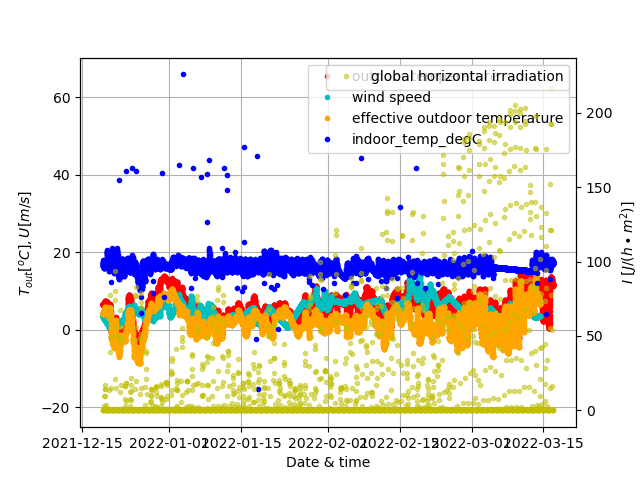

In [26]:
# plot retrieved data

property = 'indoor_temp_degC'

%matplotlib widget
import pylab as plt

fig, ax = plt.subplots()

ax.grid(True)
# ax.xaxis.grid(True)
# ax.yaxis.grid(True)


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel(r'$I\ [J/(h \bullet m^2)]$')
ax2.plot(weather.index, weather['Q'], '.', label='global horizontal irradiation', alpha=0.5, color='y')  # ... and some more.
ax2.legend(loc=1)

ax.plot(data_by_day.index, data_by_day['outdoor_temp_degC'], '.', label='outdoor temperature', color='r')  # Plot some data on the axes.
ax.plot(data_by_day.index, data_by_day['windspeed_m_per_s'], '.', label='wind speed', color='c')  # Plot more data on the axes...
ax.plot(data_by_day.index, data_by_day['effective_outdoor_temp_degC'], '.', label='effective outdoor temperature', color='orange')  # Plot more data on the axes...
ax.plot(data_by_day.index, data_by_day[property], '.', label=property, color='b')  # Plot some data on the axes.
ax.legend(loc=0);  # Add a legend.

ax.set_xlabel('Date & time')  # Add an x-label to the axes.
ax.set_ylabel(r'$T_{out} [^oC], U [m/s]$')
plt.show()

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [27]:
# Copy dataframe + add index column + change the name of "datetime obj"

df = data_by_day_total.copy()
df = df.reset_index()
df.rename(columns={'index': 'Date_Time'}, inplace=True)
df['index_col'] = df.index
delta_t = int(df['timedelta_s'][0])


In [28]:
df['Date_Time'] = df['Date_Time'].dt.tz_localize(None)
df.to_excel(file_name)

result_per_home_df = pd.DataFrame(columns=['pseudonym', 'start_point', 'end_point','duration [days]' ,'tau [h]', 'H [W/K]', 'A_eff [m^2]', 'COP_CH', 'eta_hs_CH'])

# total_result_df = pd.DataFrame(columns=['pseudonym', 'start_point', 'end_point','duration [days]' ,'tau [h]', 'H [W/K]', 'A_eff [m^2]', 'COP_CH', 'eta_hs_CH'])
# result_per_home_df.to_excel('result.xlsx')

In [29]:
from gekko import GEKKO
end_point = df.index[df['Date_Time'] == '2021-12-19 01:00:00'].tolist()[0]

duration = 7
num_iter = 11
printing_row = 11

for j in range(num_iter):
    start_point = end_point
    end_point = start_point + (duration * 24 * 4)

    # data loading
    setpoint = np.asarray(df['indoor_setpoint_temp_degC'].iloc[start_point:end_point])

    T_in_meas = np.asarray(df['indoor_temp_degC'].iloc[start_point:end_point])
    T_out_eff_arr = np.asarray(df['effective_outdoor_temp_degC'].iloc[start_point:end_point])
    time_recorded = df['Date_Time'].iloc[start_point:end_point]
    T_out = np.asarray(df['outdoor_temp_degC'].iloc[start_point:end_point])
    gas_total = np.asarray(df['gas_m^3'].iloc[start_point:end_point])

    e_used_normal_val = np.asarray(df['e_used_normal_kWh'].iloc[start_point:end_point])
    e_used_low_val = np.asarray(df['e_used_low_kWh'].iloc[start_point:end_point])

#     pv_yield_val = np.asarray(df['pv_yield_kWh'].iloc[start_point:end_point])
#     pv_used_val = np.asarray(df['pv_used_kWh'].iloc[start_point:end_point])

    e_returned_normal_val = np.asarray(df['e_returned_normal_kWh'].iloc[start_point:end_point])
    e_returned_low_val = np.asarray(df['e_returned_low_kWh'].iloc[start_point:end_point])

    delta_E_supply_val = np.asarray(e_used_normal_val + e_used_low_val)
    
#     delta_E_PV_val = np.asarray(pv_yield_val - pv_used_val)
    delta_E_PV_val = 0
    
    delta_E_ret_val = np.asarray(e_returned_normal_val + e_returned_low_val)
    delta_EV_charge_val = 0

#     delta_E_CH_val = np.asarray(df['heatpump_kWh'].iloc[start_point:end_point])
    delta_E_CH_val = 0


    delta_E_int_val = np.asarray(
        (delta_E_supply_val + delta_E_PV_val - delta_E_ret_val - delta_EV_charge_val - delta_E_CH_val) / delta_t)   # [kWh/s]
    delta_Q_int_e_val = np.asarray(delta_E_int_val * 1000 * 60 * 60)    # [W]
    I_geo_eff_val = np.asarray(df['hor_irradiation_J_per_h_per_m^2'].iloc[start_point:end_point])

    ########################################################################################################################
    #                                                   tau initial values input
    ########################################################################################################################
    # tau Input: the following value should be based on hour for tau [hr]
    tau_init_val_hr = 100
    tau_lb_hr = 10
    tau_ub_hr = 1000

    # Internal conversion (do not change this part)
    tau_init_val = tau_init_val_hr * 3600
    tau_lb = tau_lb_hr * 3600
    tau_ub = tau_ub_hr * 3600

    ########################################################################################################################
    #                                                   Gekko Model - Initialize
    ########################################################################################################################
    # initialize gekko
    m = GEKKO(remote=False)
    m.time = np.linspace(delta_t, len(T_in_meas) * delta_t, len(T_in_meas))  # [s]

    ########################################################################################################################
    #                                                   Gekko Model - Variables
    ########################################################################################################################
    """"
    Model parameter:
    tau [hr]: effective thermal inertia
    eta_hs_CH [-]: upper heating efficiency of the central heating system
    COP_CH [-]: Coef. of Performance for heat pump
    H [W/K]: specific heat loss
    A_eff [m^2]: Effective area of the imaginary solar aperture in the horizontal plane
    """
    tau = m.FV(value=tau_init_val, lb=tau_lb, ub=tau_ub);
    tau.STATUS = 1;
    tau.FSTATUS = 0;  # tau.DMAX = 10
    H = m.FV(value=300.0, lb=0, ub=1000);
    H.STATUS = 1;
    H.FSTATUS = 0;  # H.DMAX=50                #[W/K]
    # eta_hs_CH = m.FV(value=0.8, lb=0, ub=1.0); eta_hs_CH.STATUS = 1; eta_hs_CH.FSTATUS = 0;  # eta_hs_CH.DMAX = 0.25
    # COP_CH = m.FV(value=1, lb=0.1, ub=7) ; COP_CH.STATUS = 1 ; COP_CH.FSTATUS = 0 ; #COP_CH.DMAX=1
    # A_eff = m.FV(value=5, lb=1, ub=100) ; A_eff.STATUS = 1 ; A_eff.FSTATUS = 0            #[m^2]

    """"
    Constant parameter:
    h_E [J/kWh]: Convertion factor ( [kWh] to [J] ) = 1000 * 60 * 60

    h_sup [J/Nm^3]: superior calorific value of natural gas from the Groningen field = 35,170,000.00
    eta_hs_noCH [-]: upper efficiency of heating the home indirectly using gas, for other primary purposes than heating the home

    delta_Q_sol [J/s]: heat gain from solar irradiation
    delta_G_noCH [Nm^3/s]: the natural gas used for other purposes than central heating
    delta_Q_int_gas_noCH [J/s]: natural gas used for central heating

    delta_Q_int_occup [W]: internal heat gain from occupants
    delta_Q_int_occup [W] = Np * Q_int_person_avg [W]
    Np [-]: number of persons in the household living in the home
    Q_int_person_avg [W]: internal heat gain from persons
    """
    h_E = m.Param(value=60 * 60 * 1000)  # [J/kWh"], the conversion factor [kWh] to [J]
    h_sup = m.Param(value=35170000.0)  # [J/Nm^3] "superior calorific value of natural gas from the Groningen field"
    eta_hs_noCH = m.Param(value=0.34)  # eq48. and PowerPoint Slide 24 (Effective upper home for indirect heating eff.)

    eta_hs_CH = m.Param(value=0.9)
    COP_CH = m.Param(value=4)
    A_eff = m.Param(value=6)

    delta_G_noCH = m.Param(value=339.0 / (365.25 * 24 * 60 * 60))  # [Nm^3/s]
    delta_Q_int_gas_noCH = m.Param(value=delta_G_noCH * eta_hs_noCH * h_sup)  # [W]=[J/s]

    Np = m.Param(value=2.2)  # average number of people in Dutch household
    Q_int_person_avg = m.Param(value=61)  # [J/s] average heat gain for each average person with average behaviour
    delta_Q_int_occup = m.Param(value=Np * Q_int_person_avg)  # [J/s]

    """"
    Manipulated parameter:
    delta_Q_int_e [J/s]: internal heat gain from internally used electricity
    delta_Q_int_e [J/s] = delta_E_int [kWh/s] * hE [J/kWh]
    T_out_eff [K]: effective outdoor temperature
    delta_E_CH [kWh]: Electricity used for heat pump
    delta_G [Nm3/s] = Natural gas supplied to the home via the natural gas net
    I_geo_eff [W/m^2] = geospatially interpolated global horizontal irradiation
    """
    delta_Q_int_e = m.MV(value=delta_Q_int_e_val); delta_Q_int_e.STATUS = 0; delta_Q_int_e.FSTATUS = 1  # [J/s]
    T_out_eff = m.MV(value=T_out_eff_arr); T_out_eff.STATUS = 0;T_out_eff.FSTATUS = 1  # [K]
    delta_E_CH = m.MV(value=delta_E_CH_val / delta_t); delta_E_CH.STATUS = 0; delta_E_CH.FSTATUS = 1  # [kWh/s]
    delta_G = m.MV(value=gas_total / delta_t); delta_G.STATUS = 0; delta_G.FSTATUS = 1  # [Nm^3/s]
    I_geo_eff = m.MV(value=I_geo_eff_val / (60*60)); I_geo_eff.STATUS = 0; I_geo_eff.FSTATUS = 1

    """"
    Control variable:
    T_in_sim [K]: Indoor temperature
    """
    T_in_sim = m.CV(value=T_in_meas);
    T_in_sim.STATUS = 1;
    T_in_sim.FSTATUS = 1;  # T_in_sim.MEAS_GAP= 0.25

    ########################################################################################################################
    #                                               Gekko - Equations
    ########################################################################################################################
    """
    delta_Q_gain [J/s]= delta_Q_CH [J/s] + delta_Q_int [J/s] + delta_Q_sol [J/s]
    delta_Q_gain [J/s]= Heat gain
    delta_Q_CH [J/s]= Heat gain from central hearting
    delta_Q_int [J/s]= Heat gain from internal devices
    delta_Q_sol [J/s]= delta_Q_int from solar irradiation
    """

    ########################################################################################################################
    #                                               Equation - delta_Q_CH
    ########################################################################################################################
    """"
    delta_Q_CH [J/s] = (delta_G_CH [Nm3/s] * eta_hs_ch [-] * h_sup [J/Nm3]) + (delta_E_CH [kWh/s] * COP_CH [-] * hE [J/kWh])
    delta_G_CH [Nm3/s] = Natural gas used for central heating
    delta_G_CH [Nm3/s] = delta_G [Nm3/s]- delta_G_noCH [Nm3/s]
    """

    delta_G_CH = m.Intermediate(delta_G - delta_G_noCH)  # [Nm3/s]
    delta_Q_CH = m.Intermediate((delta_G_CH * eta_hs_CH * h_sup) + (delta_E_CH * COP_CH * h_E))  # [J/s]
    # delta_Q_CH = m.Intermediate((delta_Q_CH * eta_hs_CH * h_sup) + (delta_E_CH * COP_CH * h_E))  # [J/s]
    ########################################################################################################################
    #                                                   Equation - delta_Q_int
    ########################################################################################################################
    """"
    delta_Q_int [J/s]: total internal heat
    delta_Q_int [J/s]= delta_Q_int_e + delta_Q_int_occup + delta_Q_int_gas_noCH
    delta_E_int [kWh/s] = delta_E_supply [kWh/s] + delta_E_PV [kWh/s] - delta_E_ret [kWh/s] - delta_E_EVcharge [kWh/s]
    """
    delta_Q_int = m.Intermediate(delta_Q_int_e + delta_Q_int_occup + delta_Q_int_gas_noCH)  # [J/s]

    ########################################################################################################################
    #                                                   Equation - delta_Q_sol
    ########################################################################################################################
    delta_Q_sol = m.Intermediate(A_eff * I_geo_eff)  # [J/s]

    ########################################################################################################################
    #                                                    Equation - delta_Q_gain
    ########################################################################################################################
    delta_Q_gain = m.Intermediate(delta_Q_CH + delta_Q_sol + delta_Q_int)  # [J/s]

    ########################################################################################################################
    #                                                   Final Equations
    ########################################################################################################################
    C_eff = m.Intermediate(H * tau)
    m.Equation(T_in_sim.dt() == (delta_Q_gain - (H * (T_in_sim - T_out_eff))) / C_eff)

    ########################################################################################################################
    #                                                    Solve Equations
    ########################################################################################################################
    m.options.IMODE = 5
    m.options.EV_TYPE = 1  # specific objective function (L1-norm vs L2-norm)
    m.options.NODES = 2
    # m.options.CV_TYPE = 2
    # add dead-band for measurement to avoid overfitting
    # T_in_sim.MEAS_GAP = 0.25
    m.solve(disp=False)

    ########################################################################################################################
    #                                                       Result
    ########################################################################################################################
    print(
        "Start point: {} ====> End point: {}".format(df.loc[start_point, 'Date_Time'], df.loc[end_point, 'Date_Time']))
    print('Iter: ', j)
    print('effective thermal inertia: tau [hr]: ' + str(round(tau.value[0] / 3600, 2)))
    # print('upper heating efficiency of the central heating system: eta_hs [-]: ' + str(round(eta_hs_CH.value[0], 2)))
    # print('Coef. of Performance for heat pump: COP_CH [-]: ' + str(round(COP_CH.value[0], 2)))
    print('specific heat loss: H [W/K]: ' + str(round(H.value[0], 2)))
    print('Effective area of solar aperture in the horizontal plane: A_eff [m^2]: ' + str(round(A_eff.value[0], 2)))
    print('*' * 50)

    row_num = printing_row + j
    wb = openpyxl.load_workbook(filename='result.xlsx')
    ws = wb.worksheets[0]
    ws.cell(row=row_num, column=2).value = pseudonym
    ws.cell(row=row_num, column=3).value = df['Date_Time'][start_point]
    ws.cell(row=row_num, column=4).value = df['Date_Time'][end_point]
    ws.cell(row=row_num, column=5).value = duration
    ws.cell(row=row_num, column=6).value = round(tau.value[0] / 3600, 2)
    ws.cell(row=row_num, column=7).value = round(H.value[0], 2)
    ws.cell(row=row_num, column=8).value = A_eff.value[0]
    ws.cell(row=row_num, column=9).value = COP_CH.value[0]
    ws.cell(row=row_num, column=10).value = round(eta_hs_CH.value[0], 2)
    
    wb.save("result.xlsx")


    result_dict = {'pseudonym': pseudonym, 
                   'start_point': df.loc[start_point, 'Date_Time'],
                   'end_point': df.loc[end_point, 'Date_Time'],
                   'duration [days]': duration,
                   'tau [h]': round(tau.value[0] / 3600, 2), 
                   'H [W/K]': round(H.value[0], 2),
                   'A_eff [m^2]': A_eff.value[0], 
                   'COP_CH': COP_CH.value[0], 
                   'eta_hs_CH': eta_hs_CH.value[0]
                  }
    
    result_per_home_df = result_per_home_df.append(result_dict, ignore_index = True)

Start point: 2021-12-19 01:00:00 ====> End point: 2021-12-26 01:00:00
Iter:  0
effective thermal inertia: tau [hr]: 394.98
specific heat loss: H [W/K]: 51.3
Effective area of solar aperture in the horizontal plane: A_eff [m^2]: 6.0
**************************************************


/tmp/ipykernel_14811/2648979673.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_per_home_df = result_per_home_df.append(result_dict, ignore_index = True)


Start point: 2021-12-26 01:00:00 ====> End point: 2022-01-02 01:00:00
Iter:  1
effective thermal inertia: tau [hr]: 260.64
specific heat loss: H [W/K]: 25.53
Effective area of solar aperture in the horizontal plane: A_eff [m^2]: 6.0
**************************************************


/tmp/ipykernel_14811/2648979673.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_per_home_df = result_per_home_df.append(result_dict, ignore_index = True)


Start point: 2022-01-02 01:00:00 ====> End point: 2022-01-09 01:00:00
Iter:  2
effective thermal inertia: tau [hr]: 279.12
specific heat loss: H [W/K]: 31.96
Effective area of solar aperture in the horizontal plane: A_eff [m^2]: 6.0
**************************************************


/tmp/ipykernel_14811/2648979673.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_per_home_df = result_per_home_df.append(result_dict, ignore_index = True)


Start point: 2022-01-09 01:00:00 ====> End point: 2022-01-16 01:00:00
Iter:  3
effective thermal inertia: tau [hr]: 104.6
specific heat loss: H [W/K]: 43.1
Effective area of solar aperture in the horizontal plane: A_eff [m^2]: 6.0
**************************************************


/tmp/ipykernel_14811/2648979673.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_per_home_df = result_per_home_df.append(result_dict, ignore_index = True)


Start point: 2022-01-16 01:00:00 ====> End point: 2022-01-23 01:00:00
Iter:  4
effective thermal inertia: tau [hr]: 86.23
specific heat loss: H [W/K]: 34.4
Effective area of solar aperture in the horizontal plane: A_eff [m^2]: 6.0
**************************************************


/tmp/ipykernel_14811/2648979673.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_per_home_df = result_per_home_df.append(result_dict, ignore_index = True)


Start point: 2022-01-23 01:00:00 ====> End point: 2022-01-30 01:00:00
Iter:  5
effective thermal inertia: tau [hr]: 193.29
specific heat loss: H [W/K]: 44.23
Effective area of solar aperture in the horizontal plane: A_eff [m^2]: 6.0
**************************************************


/tmp/ipykernel_14811/2648979673.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_per_home_df = result_per_home_df.append(result_dict, ignore_index = True)


Start point: 2022-01-30 01:00:00 ====> End point: 2022-02-06 01:00:00
Iter:  6
effective thermal inertia: tau [hr]: 436.31
specific heat loss: H [W/K]: 22.03
Effective area of solar aperture in the horizontal plane: A_eff [m^2]: 6.0
**************************************************


/tmp/ipykernel_14811/2648979673.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_per_home_df = result_per_home_df.append(result_dict, ignore_index = True)


Start point: 2022-02-06 01:00:00 ====> End point: 2022-02-13 01:00:00
Iter:  7
effective thermal inertia: tau [hr]: 472.21
specific heat loss: H [W/K]: 26.27
Effective area of solar aperture in the horizontal plane: A_eff [m^2]: 6.0
**************************************************


/tmp/ipykernel_14811/2648979673.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_per_home_df = result_per_home_df.append(result_dict, ignore_index = True)


Start point: 2022-02-13 01:00:00 ====> End point: 2022-02-20 01:00:00
Iter:  8
effective thermal inertia: tau [hr]: 452.36
specific heat loss: H [W/K]: 20.59
Effective area of solar aperture in the horizontal plane: A_eff [m^2]: 6.0
**************************************************


/tmp/ipykernel_14811/2648979673.py:242: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_per_home_df = result_per_home_df.append(result_dict, ignore_index = True)


NameError: name 'TimeoutExpired' is not defined

In [ ]:
import pylab as plt

plt.figure()
result_per_home_df['tau [h]'].plot(x='start_point')
plt.xlabel('Date and Time')
plt.ylabel('Hour')
plt.legend()

In [ ]:
plt.figure()
result_per_home_df['H [W/K]'].plot()
plt.xlabel('Date and Time')
plt.ylabel('H [W/K]')
plt.legend()

In [ ]:
total_result_df = total_result_df.append(result_per_home_df, ignore_index = True)
total_result_df